In [24]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json
import pandas as pd
import numpy as np
import statsmodels.api as sm
import wget
import subprocess
import os

In [32]:
# Make a data folder
if not os.path.isdir("data"):
    os.mkdir("data")

# Make yield folder
if not os.path.isdir("data/yield"):
    os.mkdir("data/yield")

# Make ushcn folder
if not os.path.isdir("data/ushcn"):
    os.mkdir("data/ushcn")

# Make counties folder
if not os.path.isdir("data/counties"):
    os.mkdir("data/counties")

## Corn yield data

In [13]:
# # Make API call
# url = "http://quickstats.nass.usda.gov/api/api_GET/?" + \
#     "key={}&".format(os.environ["NASS_API_KEY"]) + \
#     "commodity_desc=CORN&" + \
#     "group_desc=FIELD CROPS&" + \
#     "sector_desc=CROPS&" + \
#     "source_desc=SURVEY&" + \
#     "statisticcat_desc=YIELD&" + \
#     "short_desc__NOT_LIKE=SILAGE&" + \
#     "county_ansi__NE=''&" + \
#     "year__GE=2000&" + \
#     "state_ansi__NE=''&" + \
#     "format=JSON"

# response = requests.get(url)  

# # Create DataFrame
# data = response.json()
# df = pd.DataFrame(data["data"])

# # Clean the data
# df["Value"] = df.Value.map(float)
# df["year"] = df.year.map(int) - 2000

# # Save data
# df.to_csv("data/yield/yield_data.csv", index=False)

In [14]:
df = pd.read_csv("data/yield/yield_data.csv")
df.to_dict(outtype="records")[0]

{'CV (%)': nan,
 'Value': 191.5,
 'agg_level_desc': 'COUNTY',
 'asd_code': 10,
 'asd_desc': 'NORTHERN VALLEY',
 'begin_code': 0,
 'class_desc': 'ALL CLASSES',
 'commodity_desc': 'CORN',
 'congr_district_code': nan,
 'country_code': 9000,
 'country_name': 'UNITED STATES',
 'county_ansi': 33,
 'county_code': 33,
 'county_name': 'COLBERT',
 'domain_desc': 'TOTAL',
 'domaincat_desc': 'NOT SPECIFIED',
 'end_code': 0,
 'freq_desc': 'ANNUAL',
 'group_desc': 'FIELD CROPS',
 'load_time': '2015-02-19 15:38:52',
 'location_desc': 'ALABAMA, NORTHERN VALLEY, COLBERT',
 'prodn_practice_desc': 'ALL PRODUCTION PRACTICES',
 'reference_period_desc': 'YEAR',
 'region_desc': nan,
 'sector_desc': 'CROPS',
 'short_desc': 'CORN, GRAIN - YIELD, MEASURED IN BU / ACRE',
 'source_desc': 'SURVEY',
 'state_alpha': 'AL',
 'state_ansi': 1,
 'state_fips_code': 1,
 'state_name': 'ALABAMA',
 'statisticcat_desc': 'YIELD',
 'unit_desc': 'BU / ACRE',
 'util_practice_desc': 'GRAIN',
 'watershed_code': 0,
 'watershed_desc':

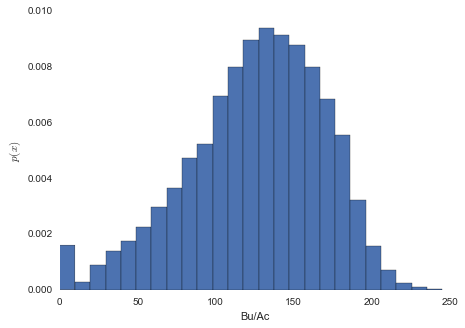

In [15]:
# Distribution of yield in Bu/Ac
plt.figure(figsize=(7, 5))
plt.hist(df.Value, bins=25, normed=True)
plt.xlabel("Bu/Ac")
plt.ylabel("$p(x)$")
plt.show()

In [16]:
# Fit OLS
X = sm.add_constant(df.year)
ols = sm.OLS(df.Value, X)
model = ols.fit()
b0, b1 = model.params.const, model.params.year
print model.summary().as_text()

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     1539.
Date:                Thu, 16 Apr 2015   Prob (F-statistic):               0.00
Time:                        07:05:59   Log-Likelihood:            -1.6905e+05
No. Observations:               32683   AIC:                         3.381e+05
Df Residuals:                   32681   BIC:                         3.381e+05
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        111.6619      0.426    262.336      0.000       110.828   112.496
year           2.1615      0.055     39.232      0.0

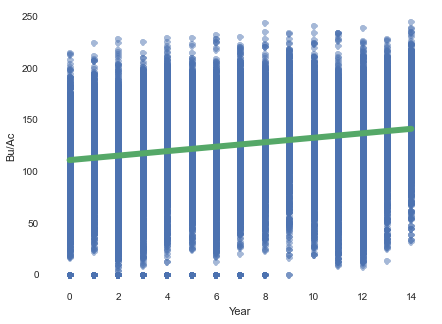

In [17]:
# Plot Bu/Ac vs. Year in Nebraska
xx = np.linspace(0, 14)
plt.figure(figsize=(7, 5))
plt.plot(df.year, df.Value, 'o', alpha=.5)
plt.plot(xx, b0 + b1*xx, lw=6)
plt.xlabel("Year")
plt.ylabel("Bu/Ac")
plt.xlim([-1, 15])
plt.ylim([-10, 260])
plt.show()

## Weather data

In [30]:
# url = "http://cdiac.ornl.gov/ftp/ushcn_daily/us.txt.gz"
# wget.download(url, out="data/ushcn/ushcn_daily.txt.gz")
# subprocess.call(["unpigz", "data/ushcn/ushcn_daily.txt.gz"])

# url = "http://cdiac.ornl.gov/ftp/ushcn_daily/ushcn-stations.txt"
# wget.download(url, out="data/ushcn/ushcn_stations.txt")

# url = "http://cdiac.ornl.gov/ftp/ushcn_daily/data_format.txt"
# wget.download(url, out="data/ushcn/data_format.txt")

'data/ushcn/data_format.txt'

In [31]:
!cat data/ushcn/data_format.txt

USHCN daily data are available as ASCII files. 
The format of each record in an ASCII data file, be it a state-level 
file (e.g., state01_AL.txt) or the file for the entire U.S. (us.txt) 
is as follows. (Each record in a file contains one month of daily data.)

Variable 	  	Columns 	  	Type
COOP ID 	  	1-6 	  	Character
YEAR	 	  	7-10 	  	Integer
MONTH 		  	11-12 	  	Integer
ELEMENT 	  	13-16 	  	Character
VALUE1 		  	17-21 	  	Integer
MFLAG1 		  	22 	  	Character
QFLAG1 		  	23 	  	Character
SFLAG1 		  	24 	  	Character
VALUE2 		  	25-29 	  	Integer
MFLAG2 		  	30 	  	Character
QFLAG2 		  	31 	  	Character
SFLAG2 		  	32 	  	Character
. 	  	. 	  	.
. 	  	. 	  	.
. 	  	. 	  	.
. 	  	. 	  	.
VALUE31 	  	257-261 	Integer
MFLAG31 	  	262 	  	Character
QFLAG31 	  	263 	  	Character
SFLAG31 	  	264 	  	Character

These variables have the following definitions:

COOP ID 	is the U.S. Cooperative Observer Network station identification
		code. Note that the first two digits in the Coop Id corr

In [23]:
!head data/ushcn_stations.txt

011084  31.0581  -87.0547   25.9 AL BREWTON 3 SSE                  ------ ------ ------ +6
012813  30.5467  -87.8808    7.0 AL FAIRHOPE 2 NE                  ------ ------ ------ +6
013160  32.8347  -88.1342   38.1 AL GAINESVILLE LOCK               011694 ------ ------ +6
013511  32.7017  -87.5808   67.1 AL GREENSBORO                     ------ ------ ------ +6
013816  31.8700  -86.2542  132.0 AL HIGHLAND HOME                  ------ ------ ------ +6
015749  34.7442  -87.5997  164.6 AL MUSCLE SHOALS AP               ------ ------ ------ +6
017157  34.1736  -86.8133  243.8 AL SAINT BERNARD                  ------ ------ ------ +6
017304  34.6736  -86.0536  187.5 AL SCOTTSBORO                     ------ ------ ------ +6
017366  32.4100  -87.0153   44.8 AL SELMA                          ------ ------ ------ +6
018024  33.4164  -86.1350  136.6 AL TALLADEGA                      ------ ------ ------ +6


## Counties

In [34]:
# url = "http://www2.census.gov/geo/docs/reference/codes/files/national_county.txt"
# wget.download(url, out="data/counties/county_codes.txt")

In [35]:
!head data/counties/county_codes.txt